<a href="https://colab.research.google.com/github/MehediH/gitgat/blob/master/ai_cw.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch
from torch import nn
from torch.utils import data
import matplotlib.pyplot as plt
import numpy as np


# Creating the training dataset and dataloader

In [3]:
Nf = 2000 # the number of different functions f that we will generate
Npts = 40 # the number of x values that we will use to generate each fa
x = torch.zeros(Nf, Npts, 1)
for k in range(Nf):
    x[k,:,0] = torch.linspace(-2, 2, Npts)

x += torch.rand_like(x)*0.1
a = -2 + 4*torch.rand(Nf).view(-1,1).repeat(1, Npts).unsqueeze(2)

y = a * torch.sin(x+a) #  y= f_a(x) = a ∗ sin(x + a)

dataset = data.TensorDataset(x, y)
data_iter = data.DataLoader(dataset, batch_size=128)
# data_iterator = iter(data_iter)

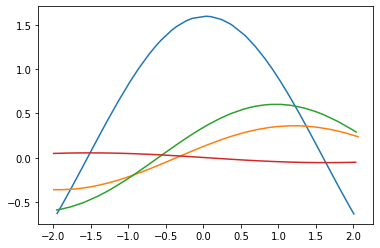

In [4]:
plt.plot(x[0,:], y[0,:])
plt.plot(x[1,:], y[1,:])
plt.plot(x[2,:], y[2,:])
plt.plot(x[3,:], y[3,:])

# Creating the Encoder and Decoder

In [5]:
class Encoder(torch.nn.Module):
    def __init__(self, num_inputs, num_hidden, num_outputs):
        super(Encoder, self).__init__()

        self.num_inputs = num_inputs
        self.num_hidden = num_hidden
        self.num_outputs = num_outputs

        self.Linear1 = nn.Linear(num_inputs, num_hidden)
        self.ReLU = nn.PReLU()
        self.Linear2 = nn.Linear(num_hidden, num_outputs)

    def forward(self, x):
        out = self.Linear1(x)
        out = self.ReLU(out)
        out = self.Linear2(out)

        return out 

In [6]:
class Decoder(torch.nn.Module):
    def __init__(self, num_inputs, num_hidden, num_outputs):
        super(Decoder, self).__init__()

        self.num_inputs = num_inputs
        self.num_hidden = num_hidden
        self.num_outputs = num_outputs

        self.Linear1 = nn.Linear(num_inputs, num_hidden)
        self.ReLU = nn.PReLU()
        self.Linear2 = nn.Linear(num_hidden, num_outputs)

    def forward(self, x):
        out = self.Linear1(x)
        out = self.ReLU(out)
        out = self.Linear2(out)

        return out 

In [35]:
class EncoderDecoder(torch.nn.Module):
    def __init__(self, h_dim, r_dim):
        super(EncoderDecoder, self).__init__()

        self.h_dim = h_dim
        self.r_dim = r_dim

        self.encoder = Encoder(num_inputs=2, num_hidden=h_dim, num_outputs=r_dim)
        self.decoder = Decoder(num_inputs=r_dim+1, num_hidden=h_dim, num_outputs=1)

    def forward(self, x):
        encoderOutput = self.encoder(x)

        # compute average of the individual rC values
        rC = torch.mean(encoderOutput, dim=1)

        # combine rC values with Xt 
        rC = rC.unsqueeze(1).repeat(1, Npts, 1)
        Xt_with_rc = torch.cat([rC, X], dim=2)

        decoderOutput = self.decoder(Xt_with_rc)

        return decoderOutput 

In [40]:
r_dim = 2
h_dim = 5

def init_weights(m):
    if type(m) == nn.Linear: # by checking type we can init different layers in different ways
        torch.nn.init.kaiming_normal_(m.weight)

net = EncoderDecoder(h_dim, r_dim)
net.apply(init_weights)

EncoderDecoder(
  (encoder): Encoder(
    (Linear1): Linear(in_features=2, out_features=5, bias=True)
    (ReLU): PReLU(num_parameters=1)
    (Linear2): Linear(in_features=5, out_features=2, bias=True)
  )
  (decoder): Decoder(
    (Linear1): Linear(in_features=3, out_features=5, bias=True)
    (ReLU): PReLU(num_parameters=1)
    (Linear2): Linear(in_features=5, out_features=1, bias=True)
  )
)

# Optimizer and Loss

In [43]:
loss = nn.MSELoss()
lr, wd = 0.001, 0.0005

optim = torch.optim.Adam(net.parameters(), lr=lr, weight_decay=wd)

# Training

In [42]:
def get_context_pairs(X, y):
  # generate random Nc between 2 and 40/Npts
  Nc = int(torch.randint(2, Npts, (1,)))

  # take random Nc subset from the current element
  # without replacement
  random_subset_indices = torch.randperm(Npts)[:Nc]

  Xc = X[:,random_subset_indices]
  Yc = y[:,random_subset_indices]

  # create the context pairs from the random subset indices 
  context_pairs = torch.stack([Xc, Yc], axis=2).squeeze(3)

  return context_pairs

In [9]:
def accuracy(y_hat, y):
  if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
    y_hat = y_hat.argmax(axis=1)
  
  cmp = (y_hat.type(y.dtype) == y)

  return float(torch.sum(cmp))

class Accumulator: 
    """For accumulating sums over `n` variables."""
    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]



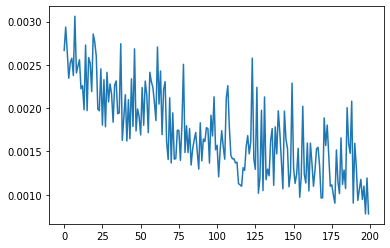

In [45]:
num_epochs = 200

train_loss = {}

for epoch in range(num_epochs):

  # Sum of training loss, sum of training accuracy, no. of examples
  metric = Accumulator(3)

  # netEncoder.train()
  # netDecoder.train()

  for X, y in data_iter: 
    context_pairs = get_context_pairs(X, y) # returns random number of context pairs (Xc, Yc)

    y_hat = net(context_pairs)

    l = loss(y_hat, y)

    optim.zero_grad()
    l.backward()
    optim.step()

    
    metric.add(float(l) * len(y), 0, y.size().numel())

  # print(f"epoch {epoch}, loss: {metric[0]/metric[2]}, accuracy: {metric[1]/metric[2]}")
  train_loss[epoch] = metric[0]/metric[2]

plt.plot(list(train_loss.keys()), list(train_loss.values()))

In [ ]:
X = torch.rand(5, 2, 1)
rC = torch.rand(5,2)

print(f"X: {X}")
print(f"rC: {rC}")

rC = rC.unsqueeze(1).repeat(1,2,1)

Xt = torch.cat([rC, X], dim=2)

Xt, Xt.shape

X: tensor([[[0.8290],
         [0.3607]],

        [[0.5578],
         [0.2635]],

        [[0.3204],
         [0.3156]],

        [[0.6359],
         [0.6502]],

        [[0.0303],
         [0.6585]]])
rC: tensor([[0.5764, 0.7551],
        [0.0796, 0.1653],
        [0.9113, 0.8752],
        [0.4112, 0.8765],
        [0.5546, 0.5428]])


(tensor([[[0.5764, 0.7551, 0.8290],
          [0.5764, 0.7551, 0.3607]],
 
         [[0.0796, 0.1653, 0.5578],
          [0.0796, 0.1653, 0.2635]],
 
         [[0.9113, 0.8752, 0.3204],
          [0.9113, 0.8752, 0.3156]],
 
         [[0.4112, 0.8765, 0.6359],
          [0.4112, 0.8765, 0.6502]],
 
         [[0.5546, 0.5428, 0.0303],
          [0.5546, 0.5428, 0.6585]]]), torch.Size([5, 2, 3]))

In [ ]:
x = torch.tensor([1, 2])
print(x)
x = x.repeat(4, 40)
print(x)

tensor([1, 2])
tensor([[1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2,
         1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2,
         1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2,
         1, 2, 1, 2, 1, 2, 1, 2],
        [1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2,
         1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2,
         1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2,
         1, 2, 1, 2, 1, 2, 1, 2],
        [1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2,
         1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2,
         1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2,
         1, 2, 1, 2, 1, 2, 1, 2],
        [1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2,
         1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2